# Model situation 1
## Goal:

We want to model a simple market with one normal, one conservative and on risk taking bank, which have different scoring functions and score dependent interest rates. Our aim is to observe the mean score change of borrowers in multiple time steps depending on the institution they choose to borrow from. The decision is based on the borrowers utility, combined with selection rate set by banks based on their utility under different policies.


# Imports

In [20]:
%load_ext autoreload
%autoreload 2
%pylab inline
import numpy as np
import random
import matplotlib
import matplotlib.pyplot as plt

import seaborn as sns

# import all of our files
import sys
sys.path.append('../')

import fico
import distribution_to_loans_outcomes as dlo
import support_functions as sf

DATA_DIR = '../data/'

# set plotting parameters
sns.set_context("talk")
sns.set_style("white")

# this needs to be here so we can edit figures later
plt.rcParams['pdf.fonttype'] = 42

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Populating the interactive namespace from numpy and matplotlib


/home/michal/.local/lib/python3.5/site-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['step', 'random']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


# Variables

In [73]:
debug = False
time_steps = 20
step = 0

#general market setting
reference_bank_name = "reference"
bank_names = ["conservative", "risk taking"]
bank_line_style = ['--', ':']
bank_color = ['red', 'blue', 'green']

#estimated number of customers in each group
white_totals = 5000#8800
black_totals = 5000#1200
loan_demand = 0.1
interest_rate_limit = 0.15

#score distribution shift
score_shifts = [40, -20]

#bank interest rate setting
score_range = [300,850]
interest_range_reference_bank = [0.24, 0.055]
interest_range_conservative_bank = [0.27, 0.04]
interest_range_risk_bank = [0.20, 0.07]
interest_change_up = 0.001
interest_change_down = -0.0005
bank_interest_rate_ranges = [interest_range_conservative_bank, interest_range_risk_bank]

# profit and impact
utility_repaid = 1
utility_default = -4

repay_score = 75
default_score = -150

#policy colors, MU, DP, EO
policy_names = ["Max. utility", "Dem. parity", "Equal opportunity" ]
policy_colors = ['green', 'blue', 'red']

#cdf groups
group_names = ["White","Black"]
group_colors = ['grey', 'black']

# Objects

In [74]:
class Market:
    def __init__(self, policy, policy_color, score_range = [300,850],repay_score = 75, default_score = -150):
        self.score_range = score_range
        self.policy = policy
        self.policy_color = policy_color
        self.repay_score = repay_score
        self.default_score = default_score
        self.step = 0
    
    def plot_bank_interest_rates(self, banks):
        plt.figure(0)
        x_axis = self.score_range
        for bank in banks:
            y_axis = bank.interest_rate_range
            plt.plot(x_axis, y_axis ,color=bank.color ,LineStyle= bank.line_style, label= bank.name + " bank interest rates")
        plt.ylabel('Interest rate')
        plt.xlabel('Score')
        plt.title('Dependence of interest rate on score for different banks')
        plt.grid('on')
        plt.legend(loc="lower left")
        plt.show()
        return 1
    
    
    def plot_bank_utility_curves(self, banks, groups):
        fig, ax = plt.subplots(len(banks),len(groups),figsize=(16,16)); 
        for i in range(len(groups)):
            for j in range(len(banks)):
                ax[i,j].plot(list(range(0,len(utility_curves[groups[i].name][j] ))), utility_curves[groups[i].name][j], color='black',LineStyle=':', label="Bank utility curve")
                ax[i,j].set_title('Utility curve of ' + str(banks[j].name) + ' bank for ' + str(groups[i].name) + ' group')
                ax[i,j].set_xlabel('Customers')
                ax[i,j].set_ylabel('Bank utility')
                ax[i,j].legend(loc="upper left")
                ax[i,j].grid()
        return 1
    
    def plot_market_situation(self, banks, groups, mean_group_score_curve):
        fig, ax = plt.subplots(3,len(groups),figsize=(16,24))
        
        for i in range(len(groups)):
            tmp_N_loans = []
            tmp_total_utility = []
            
            ax[0][i].hist(groups[i].scores, range = self.score_range, label='Step ' + str(self.step))
            ax[0][i].set_title(groups[i].name + " group histogram change for " + self.policy + " policy")
            ax[0][i].set_ylabel("Occurence")
            ax[0][i].set_xlabel("Score")
            ax[0][i].set_ylim([0,groups[i].size*0.75])
            ax[0][i].legend(loc="upper left")
            
            y_axis = mean_group_score_curve[groups[i].name]
            ax[1][1].plot(list(range(len(mean_group_score_curve[groups[i].name]))),y_axis ,color=groups[i].color, label= groups[i].name + " group mean score")
            
            for bank in banks:
                tmp_N_loans.append(bank.N_loans[groups[i].name]) 
                tmp_total_utility.append(bank.total_utility[groups[i].name])

            
            ind = np.arange(len(tmp_N_loans))  # the x locations for the groups
            width = 0.35
            
            ax[2][0].bar(ind - width/2 + i*width, tmp_N_loans, width, color=groups[i].color, label=groups[i].name)
            ax[2][1].bar(ind - width/2 + i*width, tmp_total_utility, width, color=groups[i].color, label=groups[i].name)
            ax[2][0].set_xticks(ind)
            ax[2][1].set_xticks(ind)
            
        ax[1][1].set_ylabel('Mean score')
        ax[1][1].set_xlabel('Step')
        ax[1][1].set_title('Mean score of different groups in time step:' + str(self.step))
        ax[1][1].grid()
        ax[1][1].legend(loc="lower left")
        
        
        x_axis = self.score_range
        xticklabels = []
        for bank in banks:
            y_axis = bank.interest_rate_range
            ax[1][0].plot(x_axis, y_axis ,color=bank.color ,LineStyle= bank.line_style, label= bank.name + " bank interest rates")
            xticklabels.append(bank.name + " bank")
        
        # Add some text for labels, title and custom x-axis tick labels, etc.
        ax[2][0].set_ylabel('Number of loans [log]')
        ax[2][0].set_title('Total number of loans given by bank to a group: step ' + str(self.step))
        ax[2][0].set_yscale('log')
        ax[2][0].set_xticklabels(xticklabels)
        ax[2][0].legend()
        
        ax[2][1].set_ylabel('Utility [log]')
        ax[2][1].set_title('Total bank utility by group: step ' + str(self.step))
        ax[2][1].set_yscale('log')
        ax[2][1].set_xticklabels(xticklabels)
        ax[2][1].legend()
            
            
        ax[1][0].set_ylabel('Interest rate')
        ax[1][0].set_xlabel('Score')
        ax[1][0].set_title('Dependence of interest rate on score for different banks in step:' + str(self.step))
        ax[1][0].grid()
        ax[1][0].legend(loc="lower left")
        
        #fig.savefig('../plots/MV3step'+ '%03d' % self.step +'.png')
                          
        return 1
    
    def __str__(self):
        return str(self.__class__) + ": " + str(self.__dict__)
        
class Bank:
    def __init__(self, name, color, line_style, interest_rate_range, market, score_shift=0, utility_repaid=1, utility_default= -4):
        self.name = name
        self.color = color
        self.line_style = line_style
        self.interest_rate_range = interest_rate_range
        self.score_shift = score_shift
        self.utility_repaid = utility_repaid
        self.utility_default = utility_default
        self.score_interest_rates = {}
        self.set_i_rates_mapping(market)
        self.expected_group_utility_curve = {}
        self.group_selection_rate = {}
        self.real_group_utility_curve = {}
        self.market_share = {}
        self.N_loans = {}
        self.total_utility = {}
        
    def set_i_rates_mapping(self, market):
        x_axis = np.linspace(market.score_range[0],market.score_range[1],market.score_range[1]-market.score_range[0]+1, dtype=int)
        y_axis = np.interp(x_axis, score_range, self.interest_rate_range)   
        self.score_interest_rates = dict(zip(x_axis, np.around(y_axis,4)))
        return self.score_interest_rates
    
    def get_expected_customer_score(self, market, customer_score):
        expected_customer_score = 0
        if customer_score + self.score_shift < market.score_range[0]:
            expected_customer_score = market.score_range[0]
        elif customer_score + self.score_shift > market.score_range[1]:
            expected_customer_score = market.score_range[1]
        else:
            expected_customer_score = customer_score + self.score_shift
        return expected_customer_score
    
    def get_customer_evaluation_utility(self, expected_customer_score, customer_group):
        return self.utility_default*(1-customer_group.score_repay_prob[expected_customer_score]) + (self.utility_repaid+self.score_interest_rates[expected_customer_score])*customer_group.score_repay_prob[expected_customer_score]
    
    def get_customer_utility(self, expected_customer_score, customer_group, outcome):
        utility = 0
        if outcome:
            utility = self.utility_repaid+self.score_interest_rates[expected_customer_score]
        else:
            utility = self.utility_default
        return utility
    
    def set_expected_group_utility_curve(self, customer_group, expected_utility):
        self.expected_group_utility_curve[customer_group.name] = expected_utility
        return self.expected_group_utility_curve[customer_group.name]
    
    def change_interest_rate(self, interest_change, market):
        if self.interest_rate_range[1] + interest_change >= 0:
            self.interest_rate_range[0] += interest_change
            self.interest_rate_range[1] += interest_change
            self.set_i_rates_mapping(market)
        return self.interest_rate_range
    
    def plot_expected_group_utility_curve(self, customer_group):
        plt.plot(list(range(0, len(self.expected_group_utility_curve[customer_group.name]))), self.expected_group_utility_curve[customer_group.name], color='black',LineStyle=':', label="expected bank utility curve")
        plt.ylabel('Utility')
        plt.xlabel('Customers')
        plt.title('Expected utility curve of ' + self.name + ' bank for ' + customer_group.name + ' group')
        plt.grid('on')
        plt.legend(loc="lower left")
        #plt.show()
        return 1
    
    def set_group_selection_rate(self, customer_group):
        self.group_selection_rate[customer_group.name]= (len(self.expected_group_utility_curve[customer_group.name]) - np.argmax(list(reversed(self.expected_group_utility_curve[customer_group.name])))-1)/customer_group.size
        print('Selection rate of ' + self.name + ' bank for ' + customer_group.name + ' group: ' + str(self.group_selection_rate[customer_group.name]))
        return self.group_selection_rate[customer_group.name]
    
    def __str__(self):
        return str(self.__class__) + ": " + str(self.__dict__)
        
class Customer_group:
    def __init__(self, name, color, size, scores, loan_demand, market, repays, interest_rate_limit):
        self.name = name
        self.color = color
        self.size = size
        self.scores = scores
        self.sort_scores()
        self.loan_demand = loan_demand
        self.score_repay_prob = self.get_repay_prob_mapping(market.score_range, repays)
        self.interest_rate_limit = interest_rate_limit
        
    def get_repay_prob_mapping(self, score_range, repay_prob):
        x_axis = np.linspace(score_range[0],score_range[1],score_range[1]-score_range[0]+1, dtype=int)
        y_axis = np.interp(x_axis, repay_prob.index, repay_prob[self.name])
        return dict(zip(x_axis, y_axis))
    
        #get simulated repay outcome of score probability(1=repaid, 0=default )
    def get_repay_outcome(self, repay_probability):
        random_number = random.random()
        outcome = 1
        #print(random_number)
        if random_number < 1-repay_probability:
            outcome = 0
        return outcome
    
    def get_mean_score(self):
        return np.mean(self.scores)
    
    def sort_scores(self):
        self.scores[::-1].sort()
        return self.scores
    
    def default(self, market, customer_index):
        if self.scores[customer_index] + market.default_score < market.score_range[0]:
            self.scores[customer_index] = market.score_range[0]
        else:
            self.scores[customer_index] += market.default_score
        return self.scores[customer_index]
            
    def repaid(self, market, customer_index):
        if self.scores[customer_index] + market.repay_score > market.score_range[1]:
            self.scores[customer_index] = market.score_range[1]
        else:
            self.scores[customer_index] += market.repay_score
        return self.scores[customer_index]
    
    def plot_histogram(self, market):
        plt.figure()
        plt.hist(self.scores, range = market.score_range, label='Step ' + str(market.step))
        plt.title(self.name + " group histogram change for " + market.policy + " policy")
        plt.ylabel("Occurence")
        plt.xlabel("Score")
        plt.ylim([0,self.size*0.75])
        plt.legend(loc="upper left")
        plt.show()
        return 1
        
    def __str__(self):
        return str(self.__class__) + ": " + str(self.__dict__)

# Prepare initial data

In [75]:
all_cdfs, performance, totals = fico.get_FICO_data(data_dir=DATA_DIR);
cdfs = all_cdfs[group_names]
cdf_groups = np.transpose(cdfs.values)

scores = cdfs.index
scores_list = scores.tolist()
scores_repay = cdfs.index

repays = performance[group_names]

# to get loan repay probabilities for a given score
loan_repaid_probs = [lambda i: repays[group_names[0]][scores[scores.get_loc(i,method='nearest')]], 
                     lambda i: repays[group_names[1]][scores[scores.get_loc(i,method='nearest')]]]

totals = fico.read_totals(data_dir=DATA_DIR)
##### comment to use dataset totals
totals['White'] = white_totals
totals['Black'] = black_totals
####
group_totals = np.zeros(len(group_names), dtype=np.int32)
for i in range(0,len(group_names)):
    group_totals[i] = int(totals[group_names[i]])

pis = np.zeros(cdf_groups.shape)
customer_totals = np.zeros(len(group_names), dtype=np.int32)

for i in range(0, len(group_names)): 
    pis[i] = sf.get_pmf(cdf_groups[i])
    customer_totals[i] = np.sum(np.round(pis[i]*group_totals[i]))
print("Reference group totals: " + str(group_totals))
print("Calculated group totals: " + str(customer_totals))

# demographic statistics 
group_ratio = np.array((customer_totals[0], customer_totals[1]))
group_size_ratio = group_ratio/group_ratio.sum()
print("Group size ratio: " + str(group_size_ratio))

pis_total = np.round(pis*group_totals[:, None])

ref_customer_scores = sf.get_ref_customers(customer_totals, pis_total, scores_list)

Reference group totals: [5000 5000]
Calculated group totals: [4997 5000]
Group size ratio: [ 0.49984995  0.50015005]


../fico.py:63: FutureWarning: from_csv is deprecated. Please use read_csv(...) instead. Note that some of the default arguments are different, so please refer to the documentation for from_csv when changing your function calls
  cdfs = cleanup_frame(pd.DataFrame.from_csv(data_dir + filenames[0]))
../fico.py:64: FutureWarning: from_csv is deprecated. Please use read_csv(...) instead. Note that some of the default arguments are different, so please refer to the documentation for from_csv when changing your function calls
  performance = 100 - cleanup_frame(pd.DataFrame.from_csv(data_dir + filenames[1]))
../fico.py:28: FutureWarning: from_csv is deprecated. Please use read_csv(...) instead. Note that some of the default arguments are different, so please refer to the documentation for from_csv when changing your function calls
  frame = cleanup_frame(pd.DataFrame.from_csv(data_dir + FILES['overview']))


# Create Model

In [76]:
mu_market = Market("Max. utility", 'green')
reference_bank = Bank("reference", bank_color[0],"-.", interest_range_reference_bank, mu_market, score_shifts[0])
conservative_bank = Bank("conservative", bank_color[1], "--", interest_range_conservative_bank, mu_market, score_shifts[1])
banks=[reference_bank, conservative_bank]

white_group = Customer_group("White", "grey", customer_totals[0], ref_customer_scores[0], loan_demand, mu_market, repays, interest_rate_limit)
black_group = Customer_group("Black", "black", customer_totals[1], ref_customer_scores[1], loan_demand, mu_market, repays, interest_rate_limit)
groups = [white_group, black_group]

# Next step

Selection rate of reference bank for White group: 0.754852911747
Selection rate of reference bank for Black group: 0.2592
Selection rate of conservative bank for White group: 0.629377626576
Selection rate of conservative bank for Black group: 0.1456
White group mean score: 654.732039224 at step: 0
Black group mean score: 516.6778 at step: 0
Selection rate of reference bank for White group: 0.748849309586
Selection rate of reference bank for Black group: 0.2548
Selection rate of conservative bank for White group: 0.634580748449
Selection rate of conservative bank for Black group: 0.1534
White group mean score: 658.594556734 at step: 1
Black group mean score: 517.4454 at step: 1
Selection rate of reference bank for White group: 0.744246547929
Selection rate of reference bank for Black group: 0.2504
Selection rate of conservative bank for White group: 0.639783870322
Selection rate of conservative bank for Black group: 0.1588
White group mean score: 662.254752852 at step: 2
Black group mea

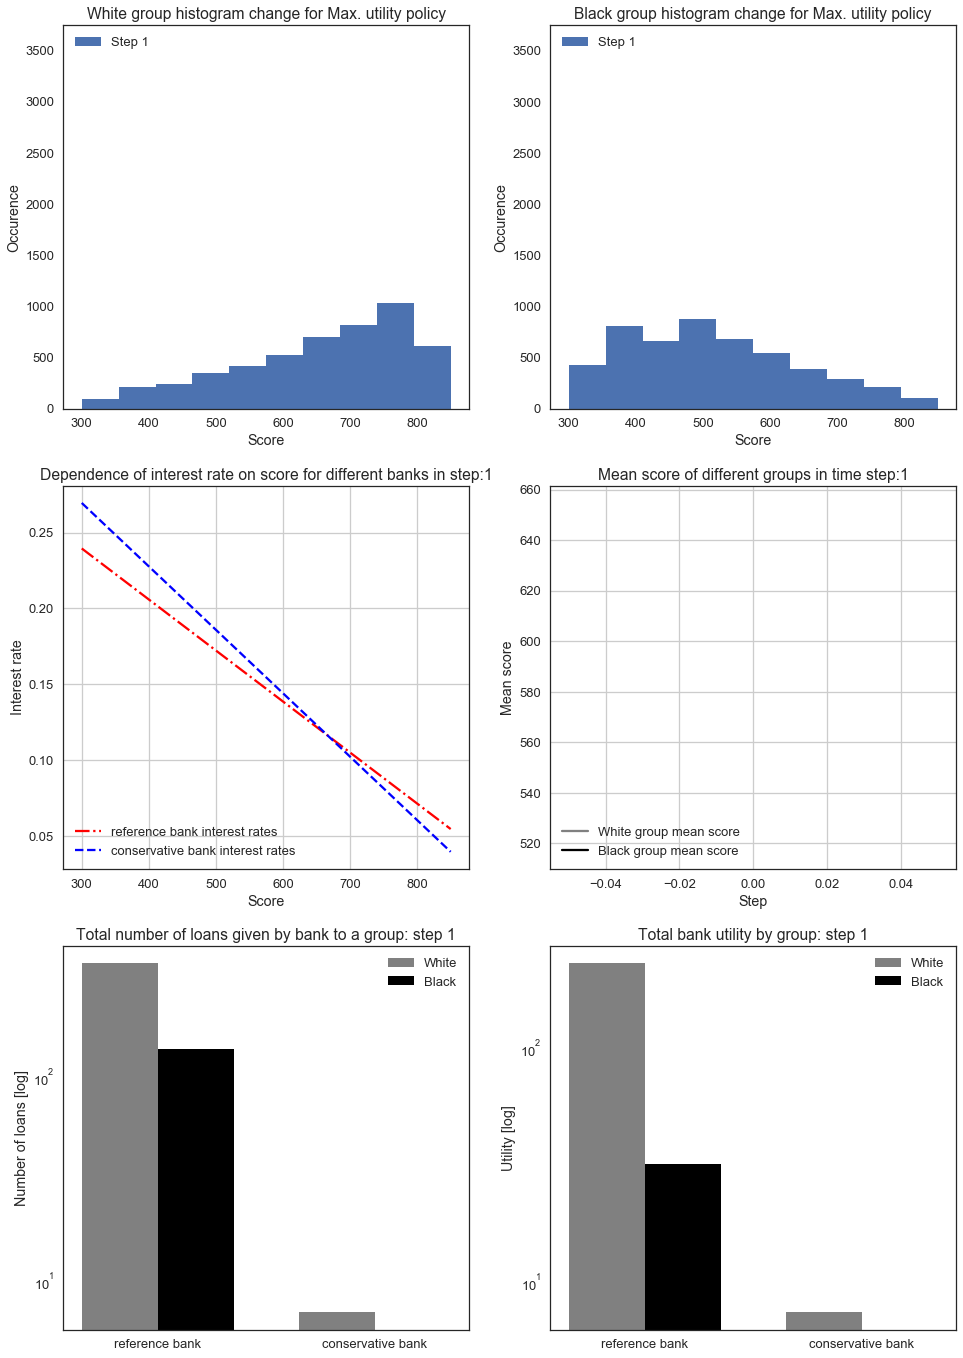

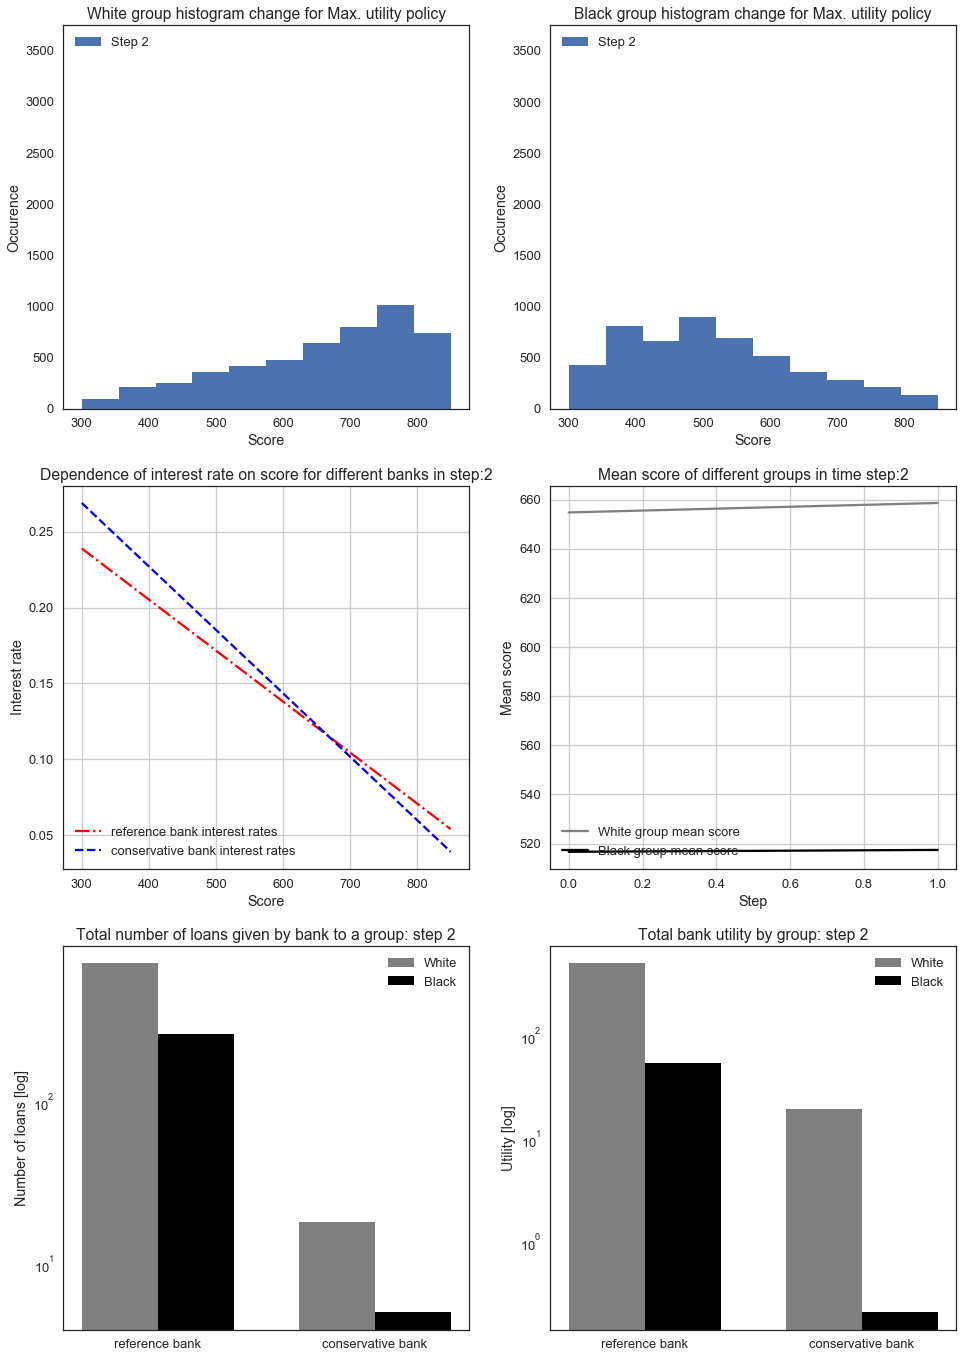

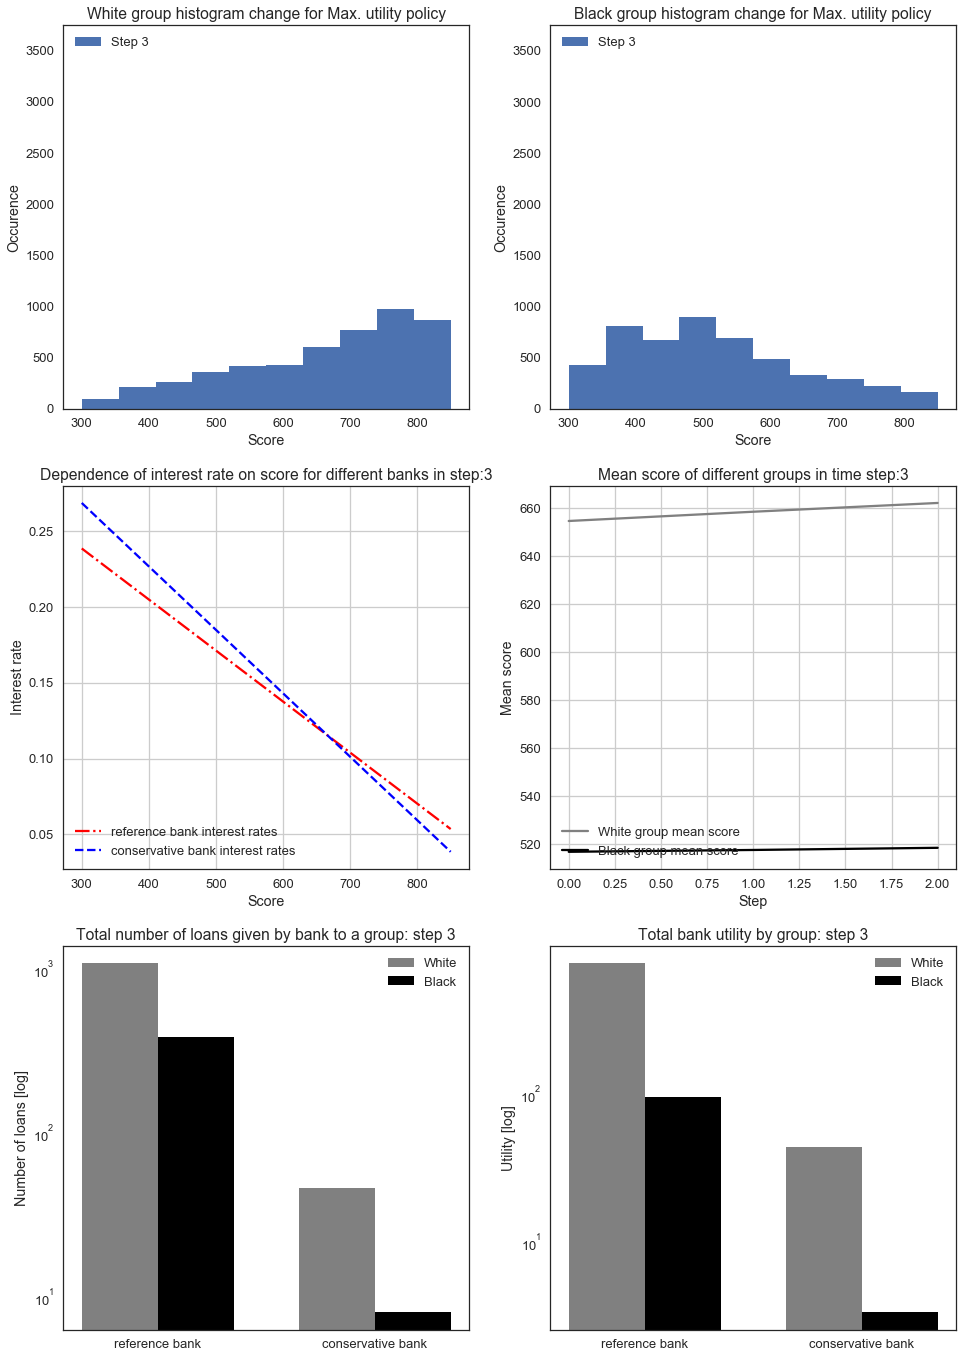

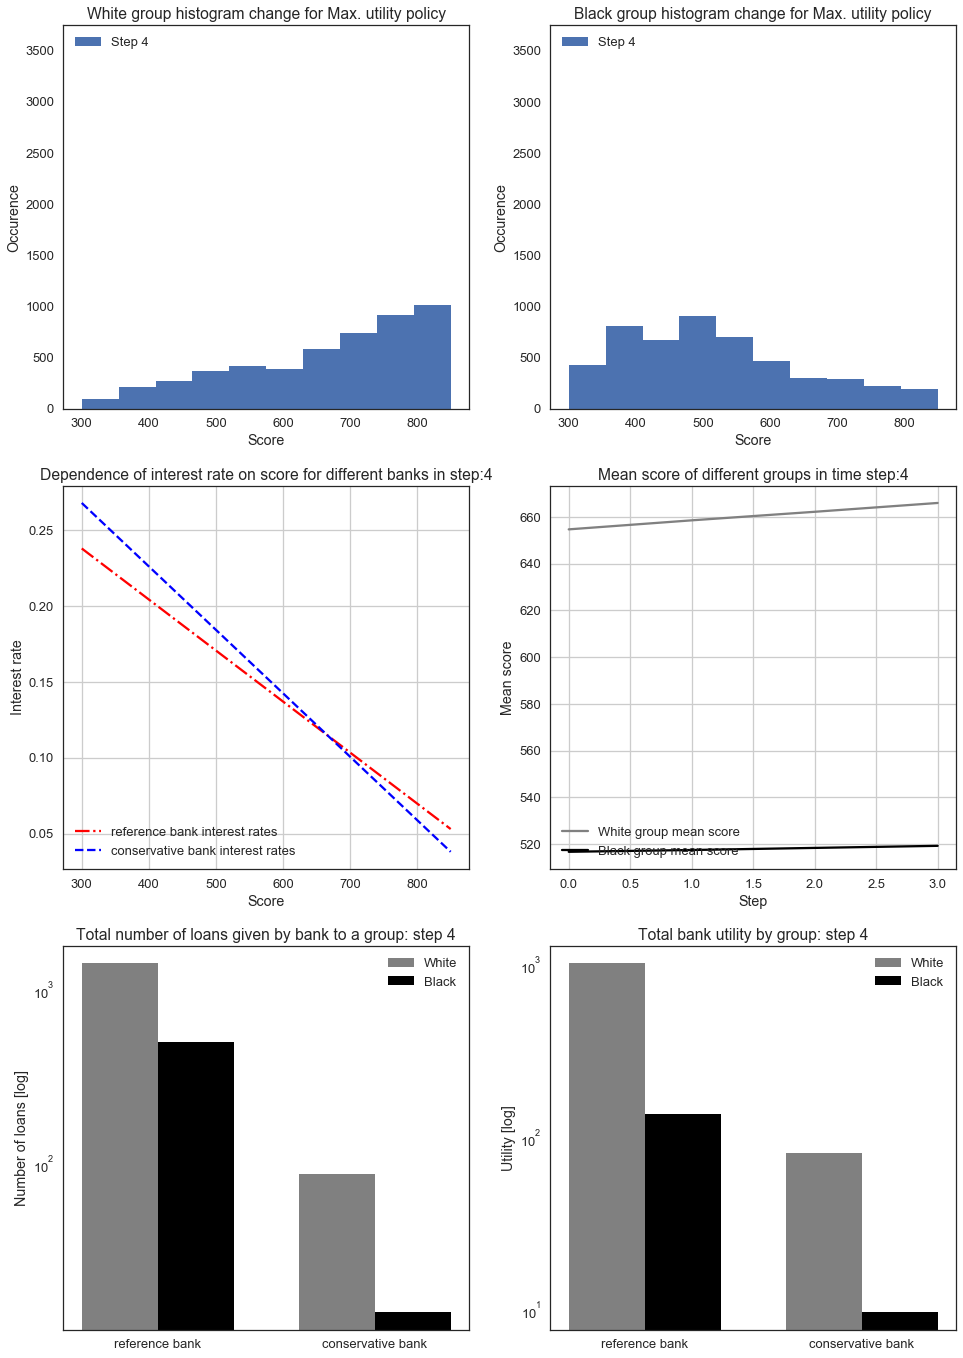

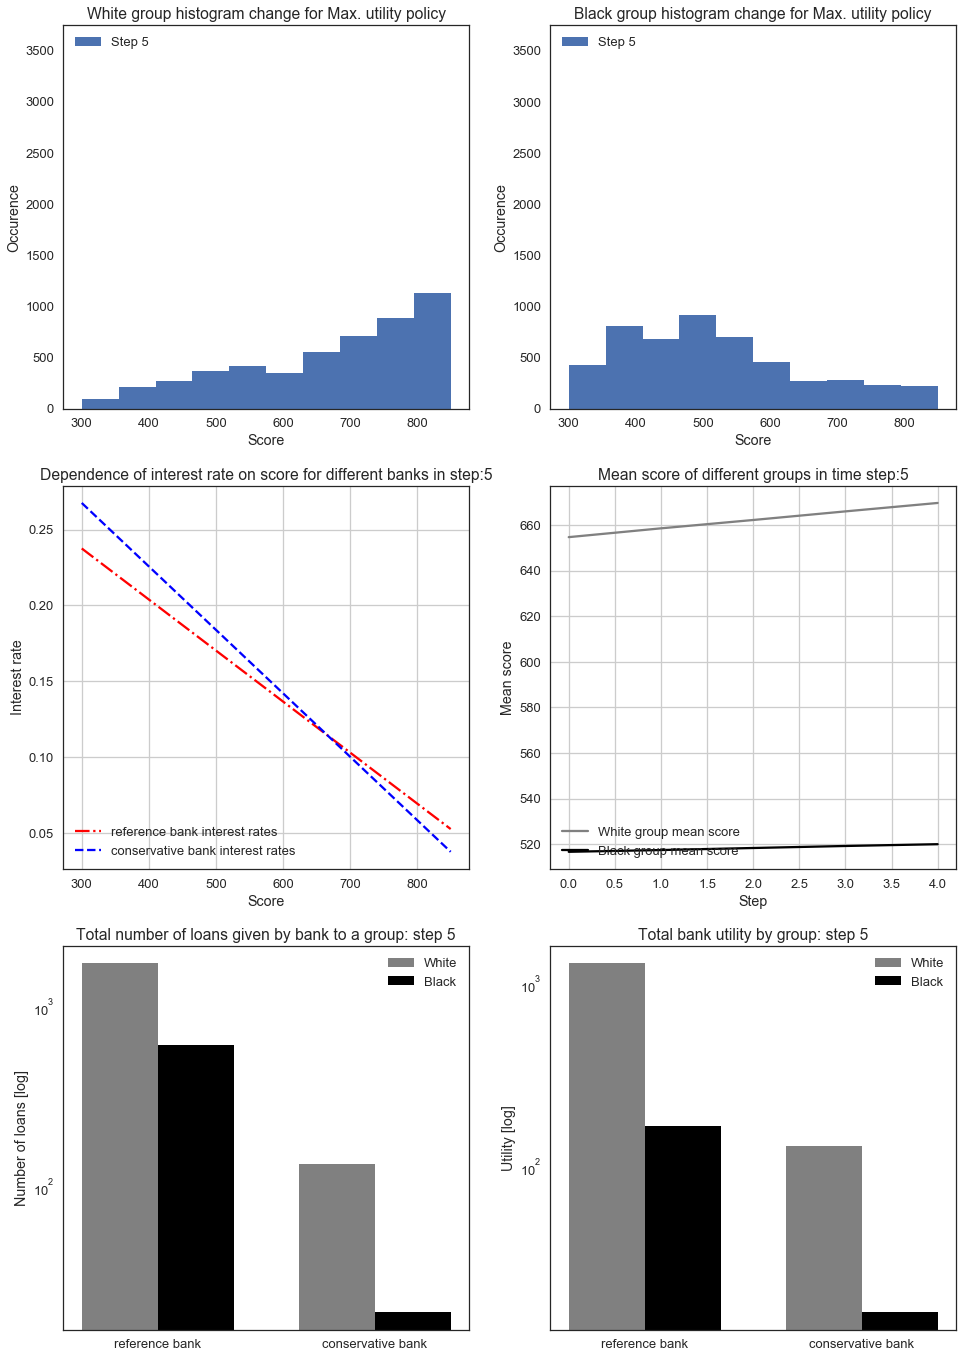

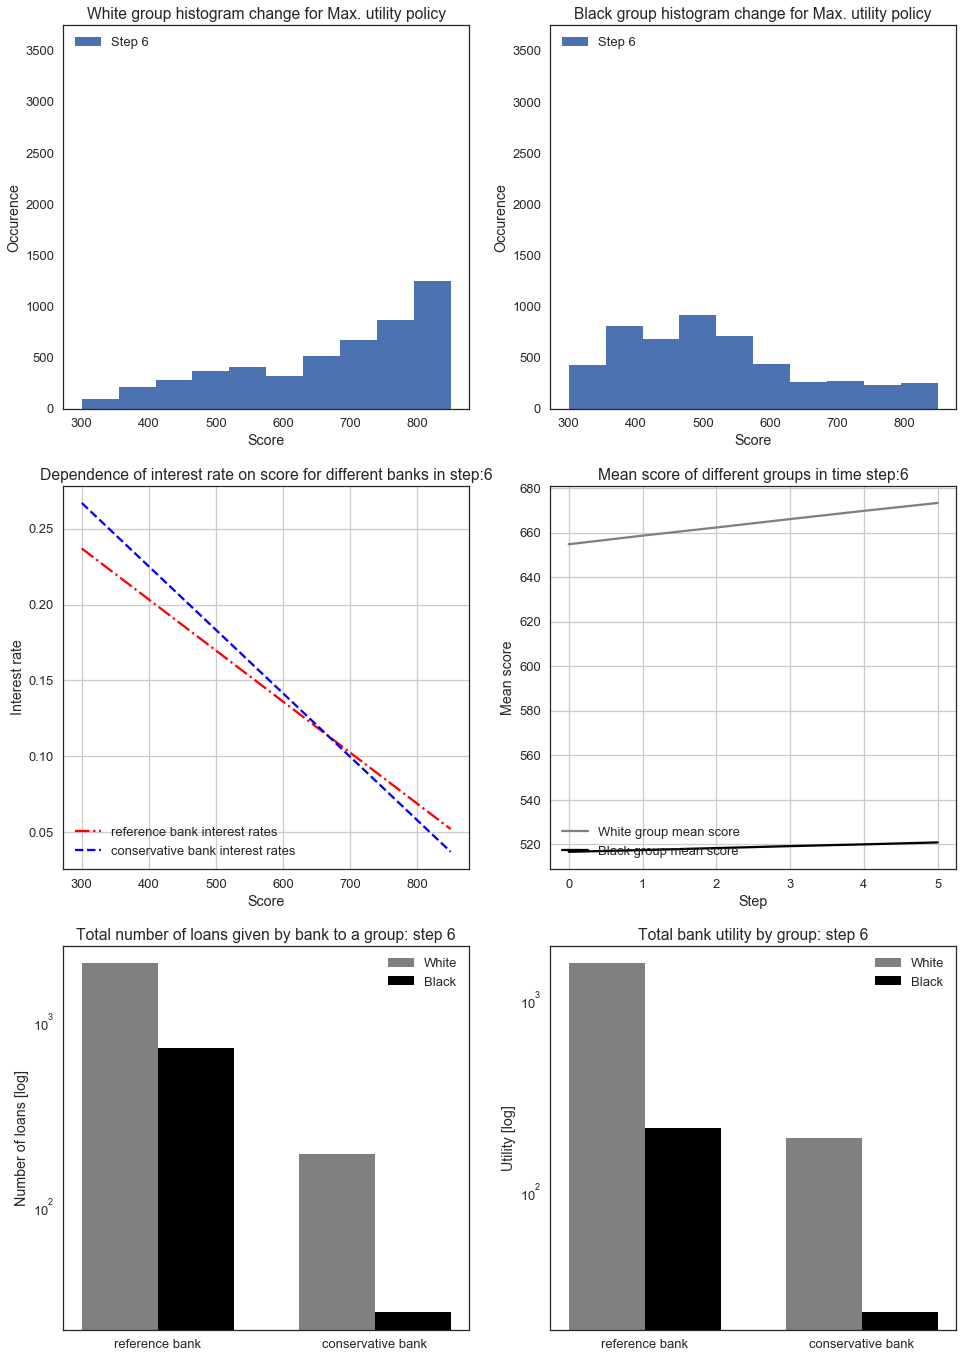

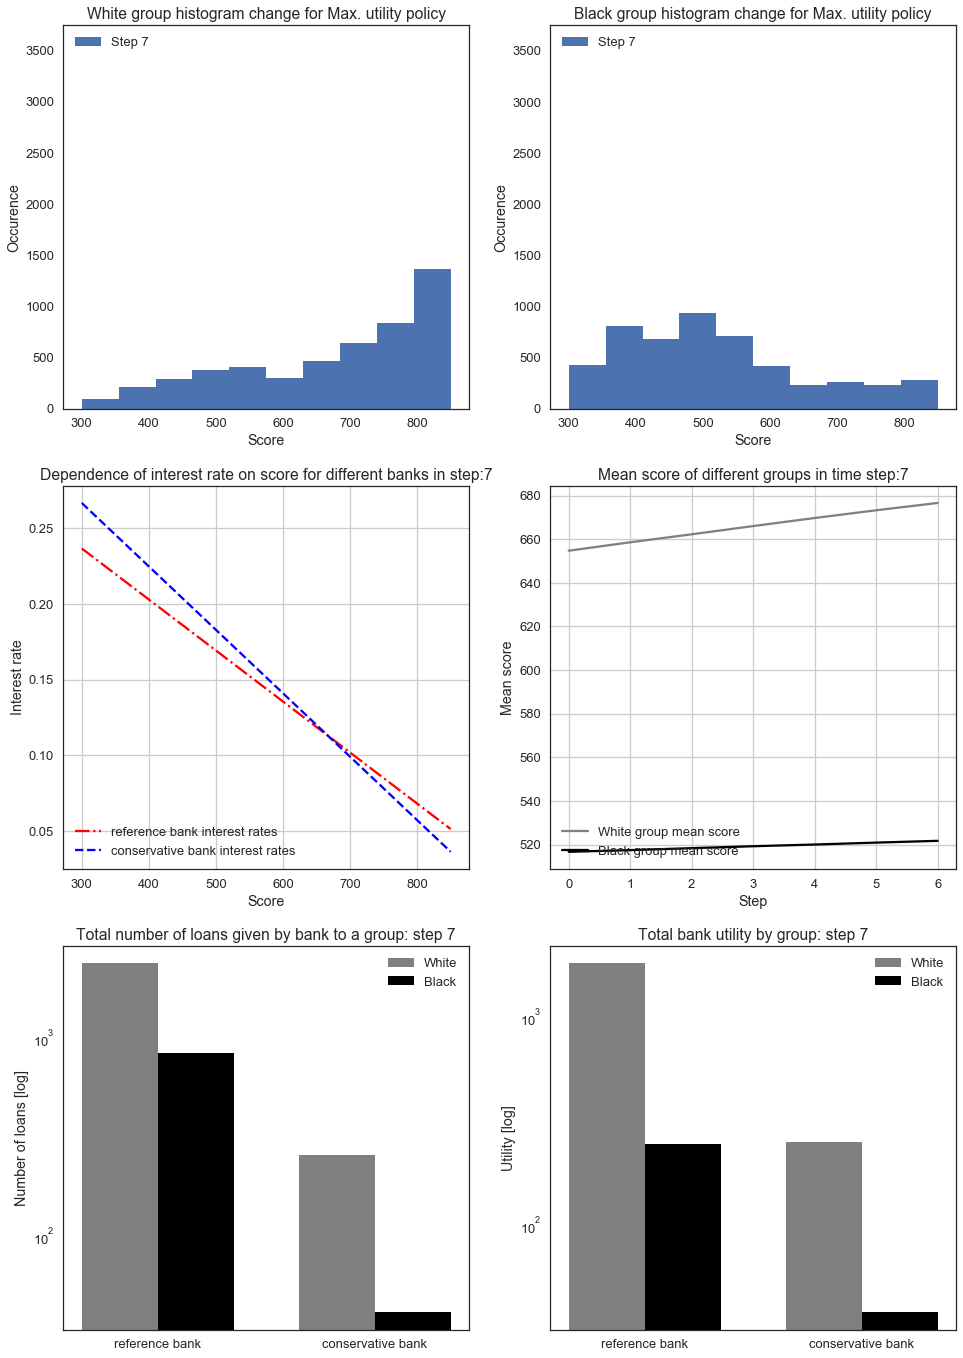

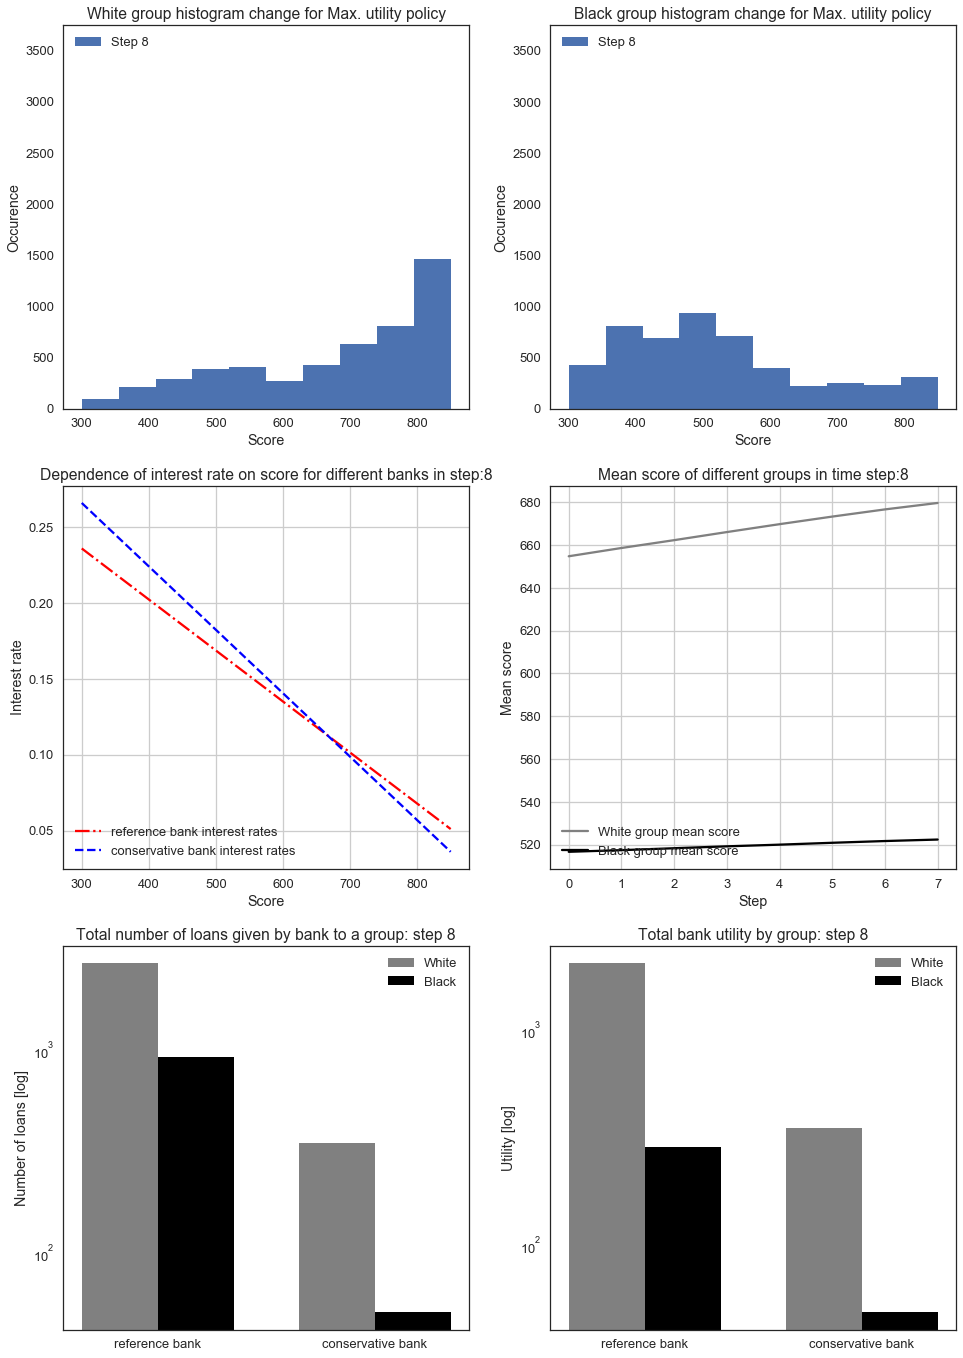

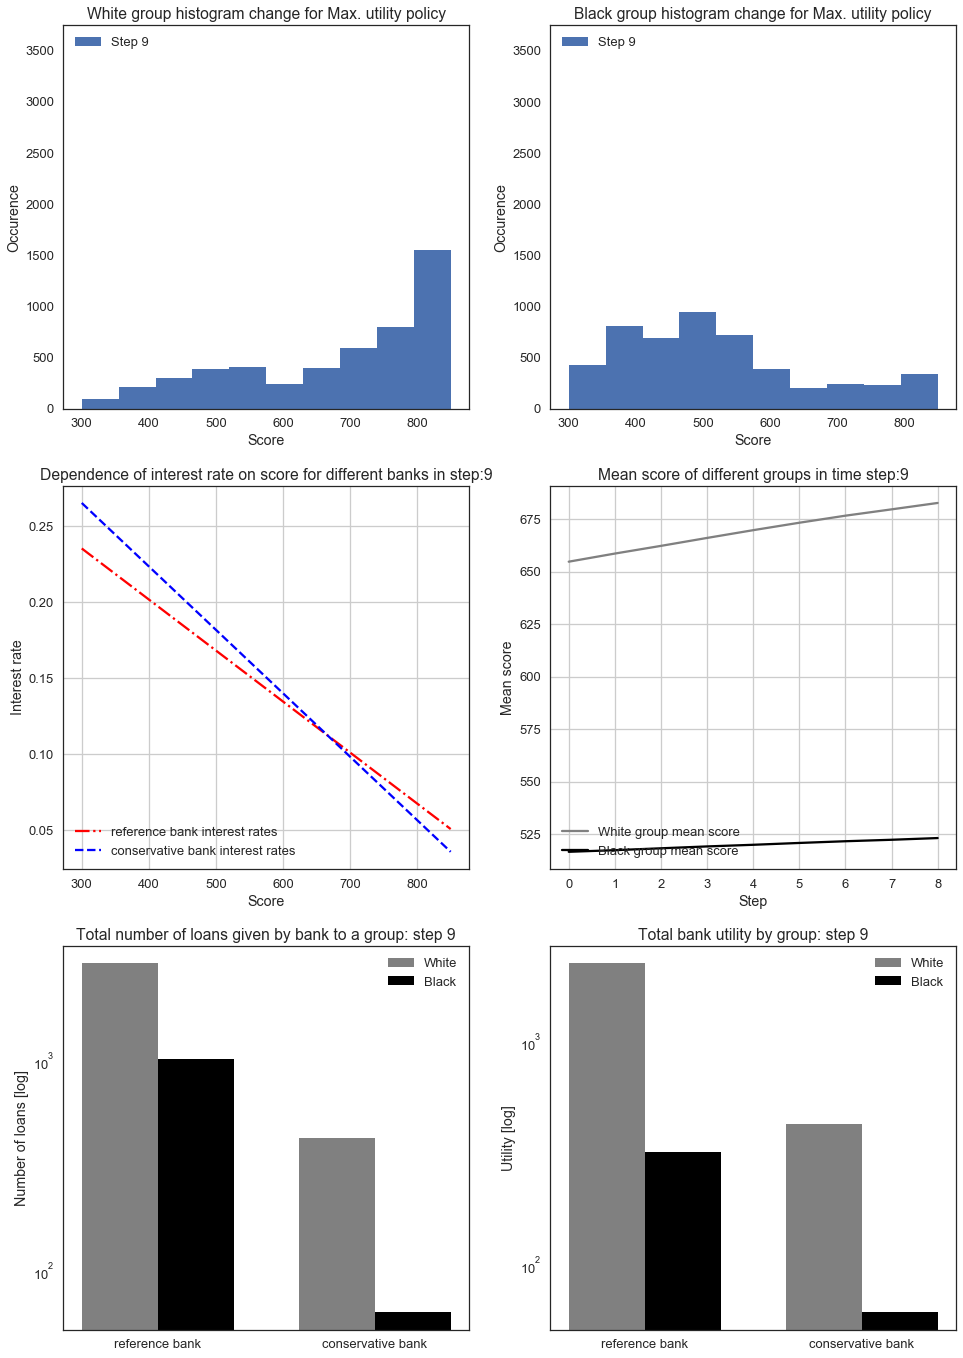

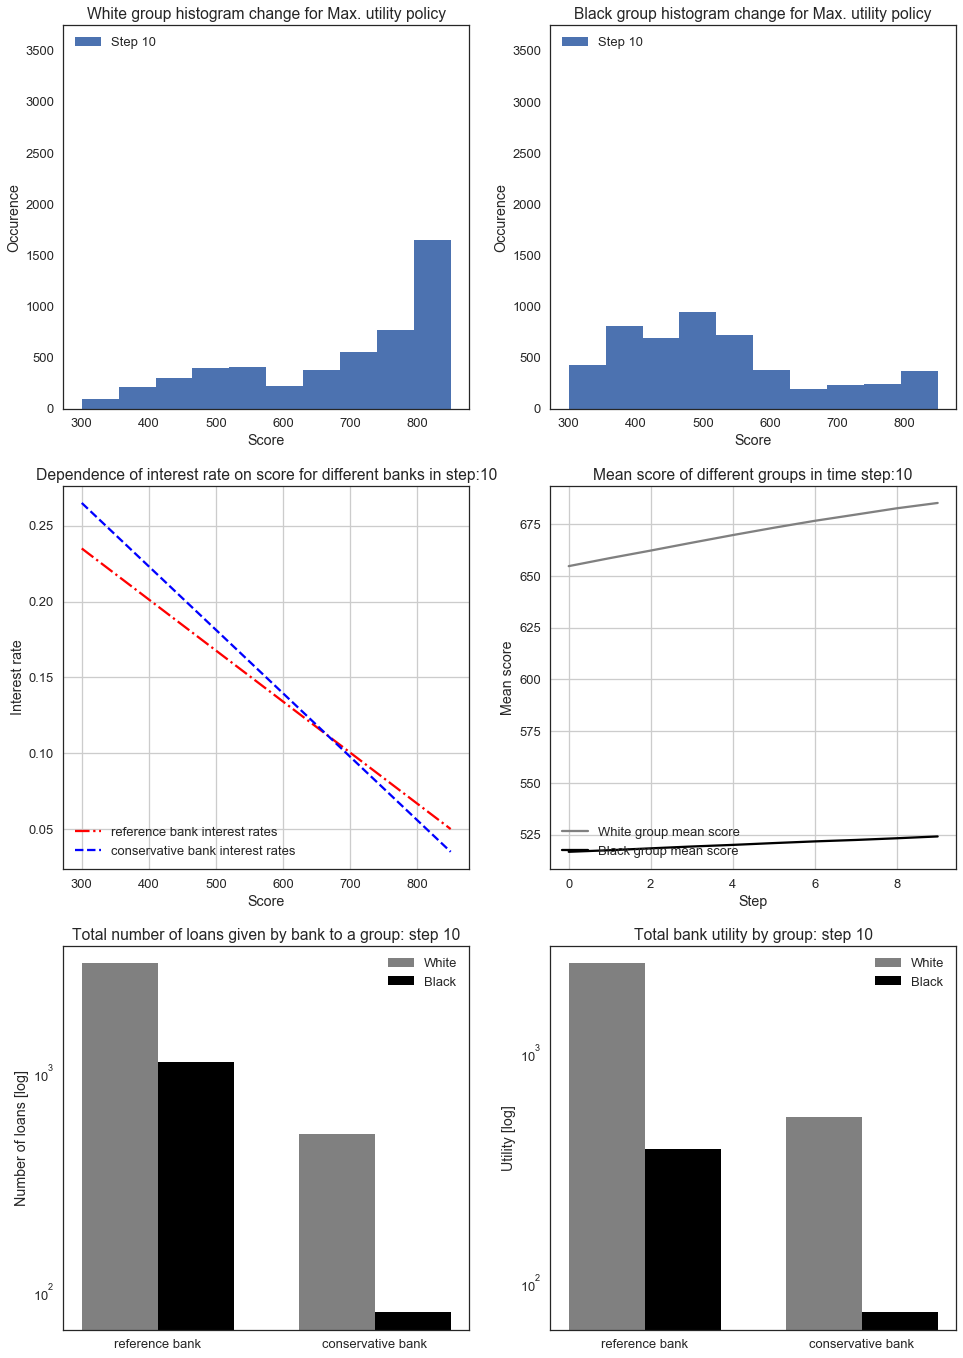

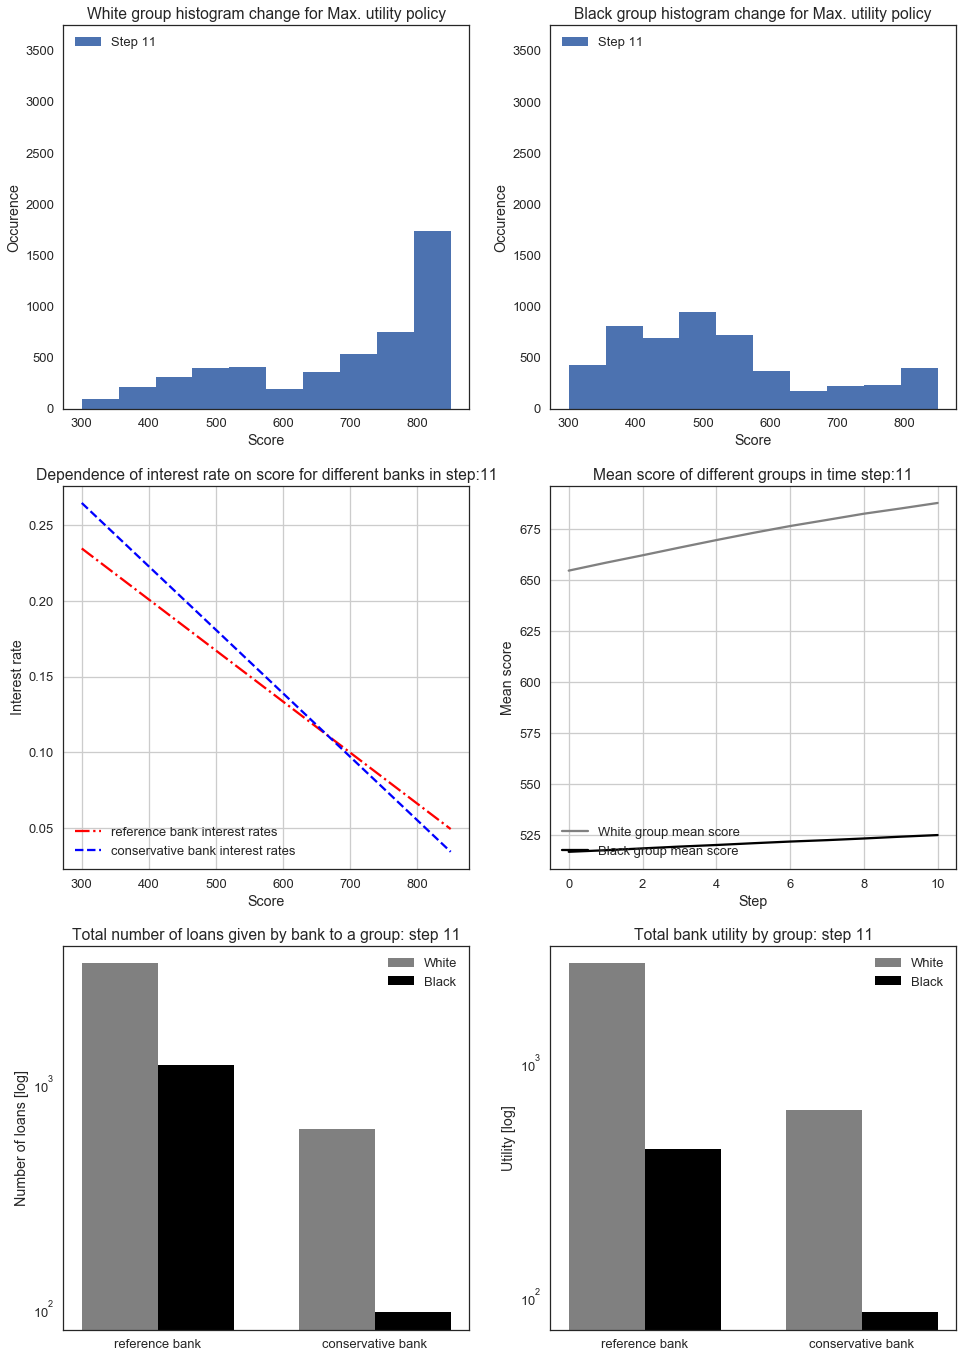

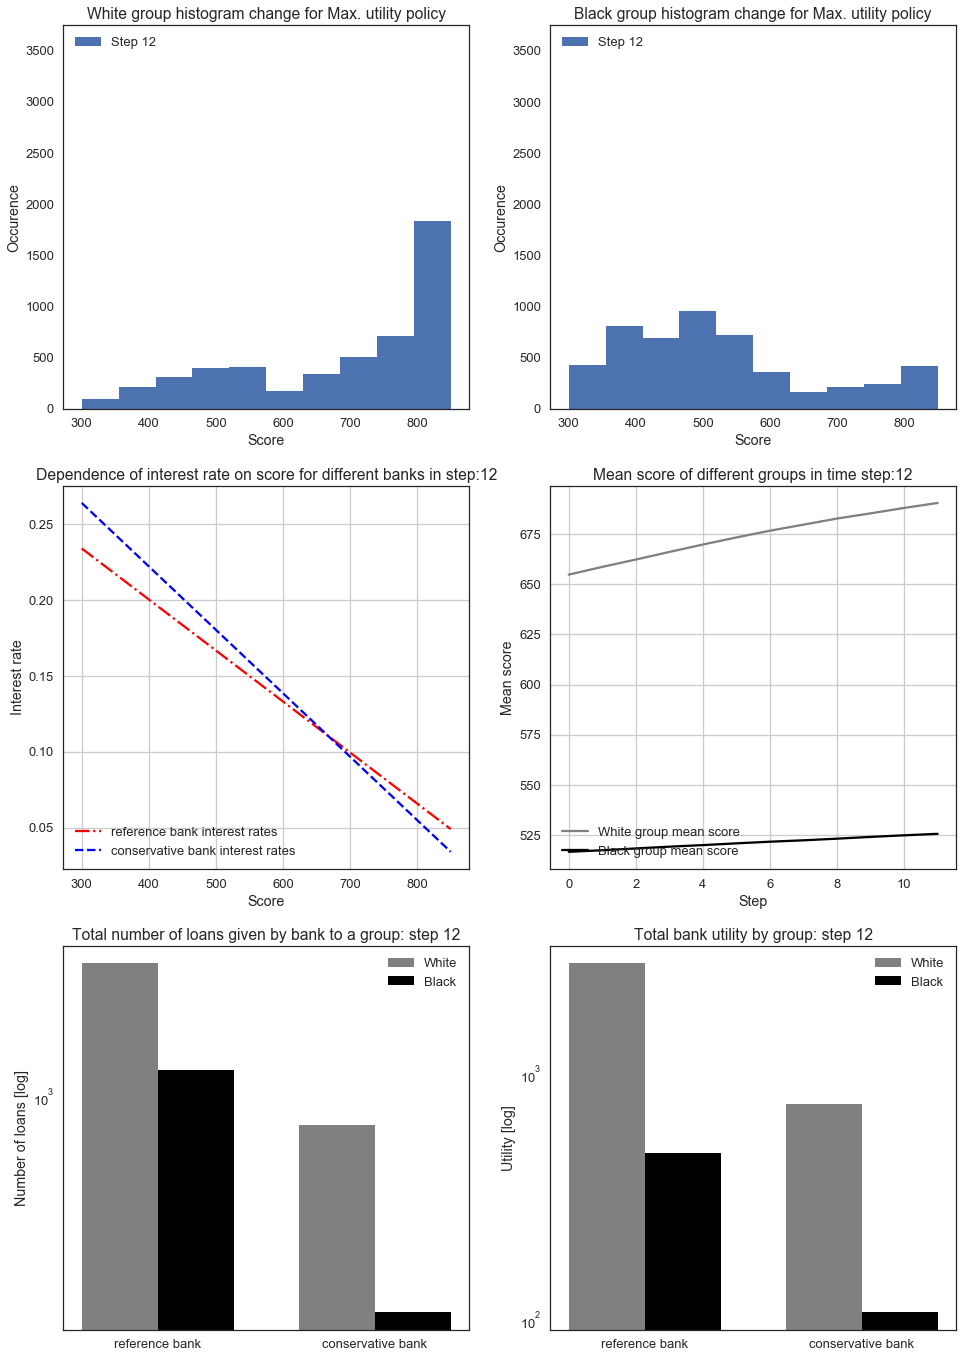

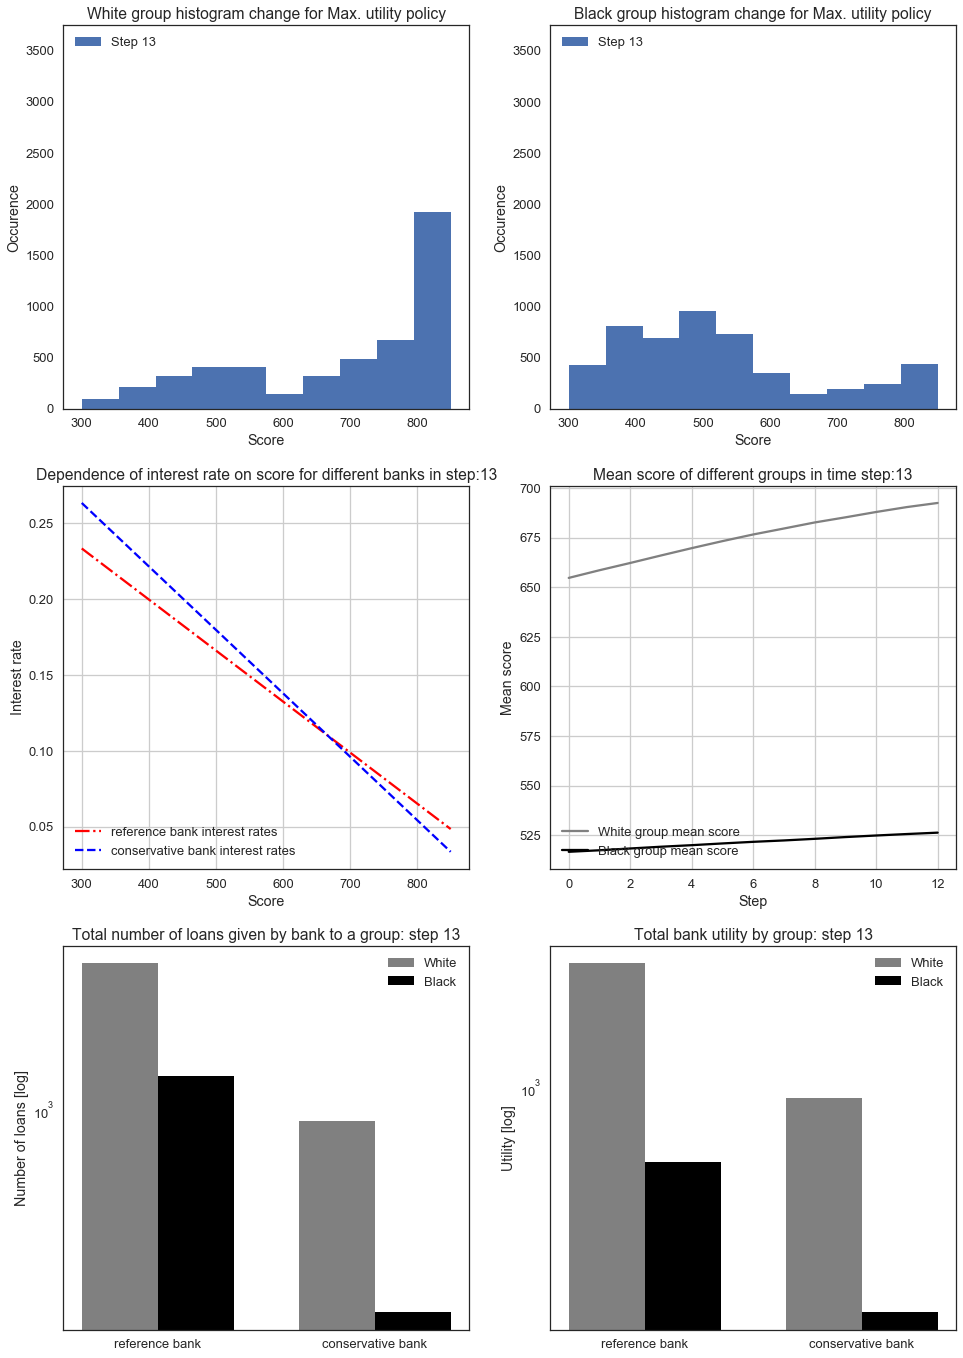

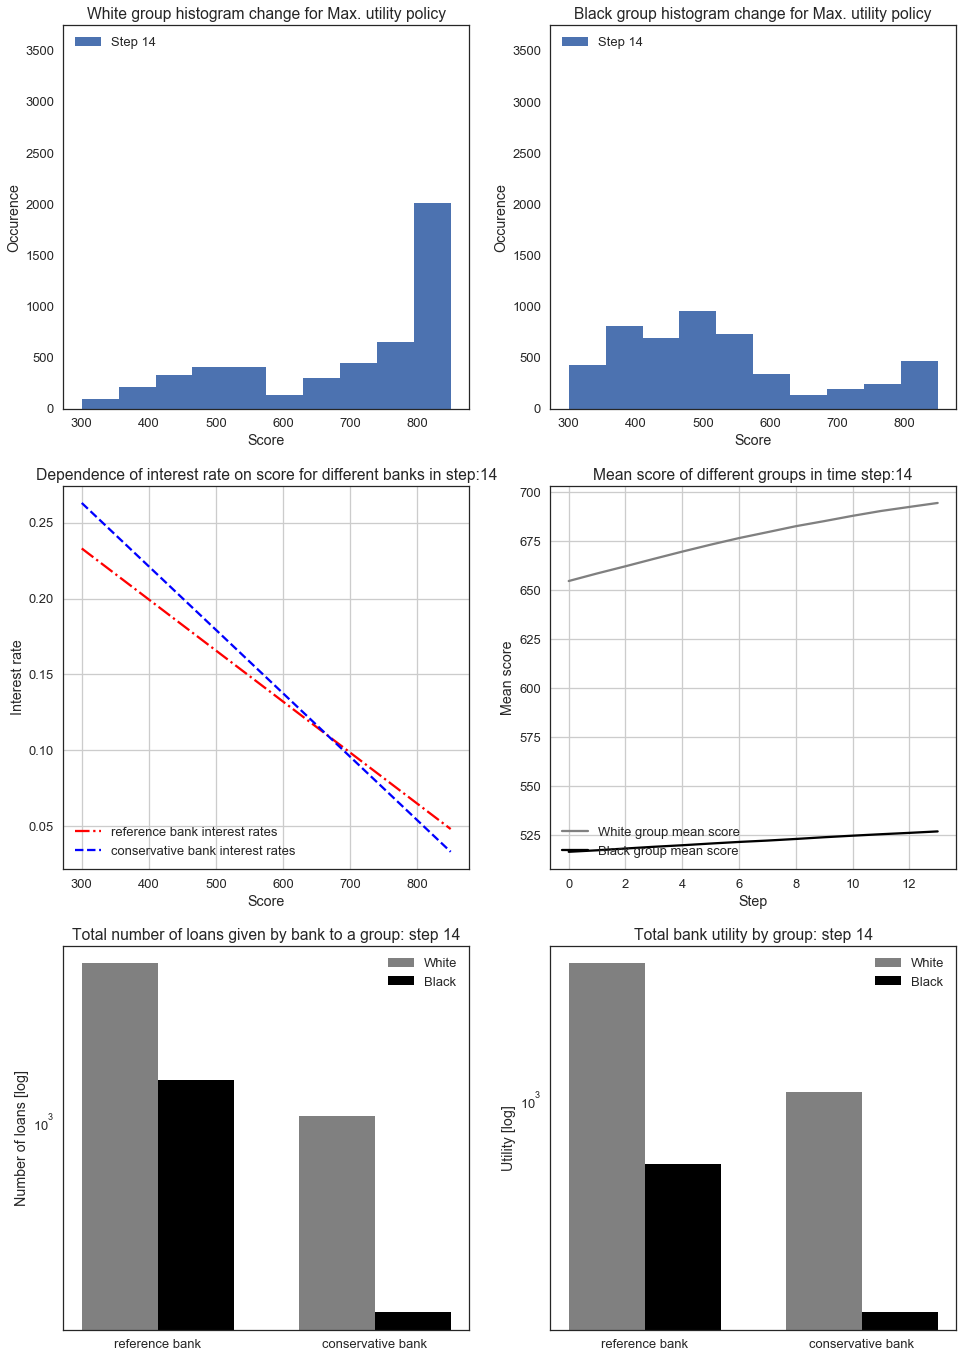

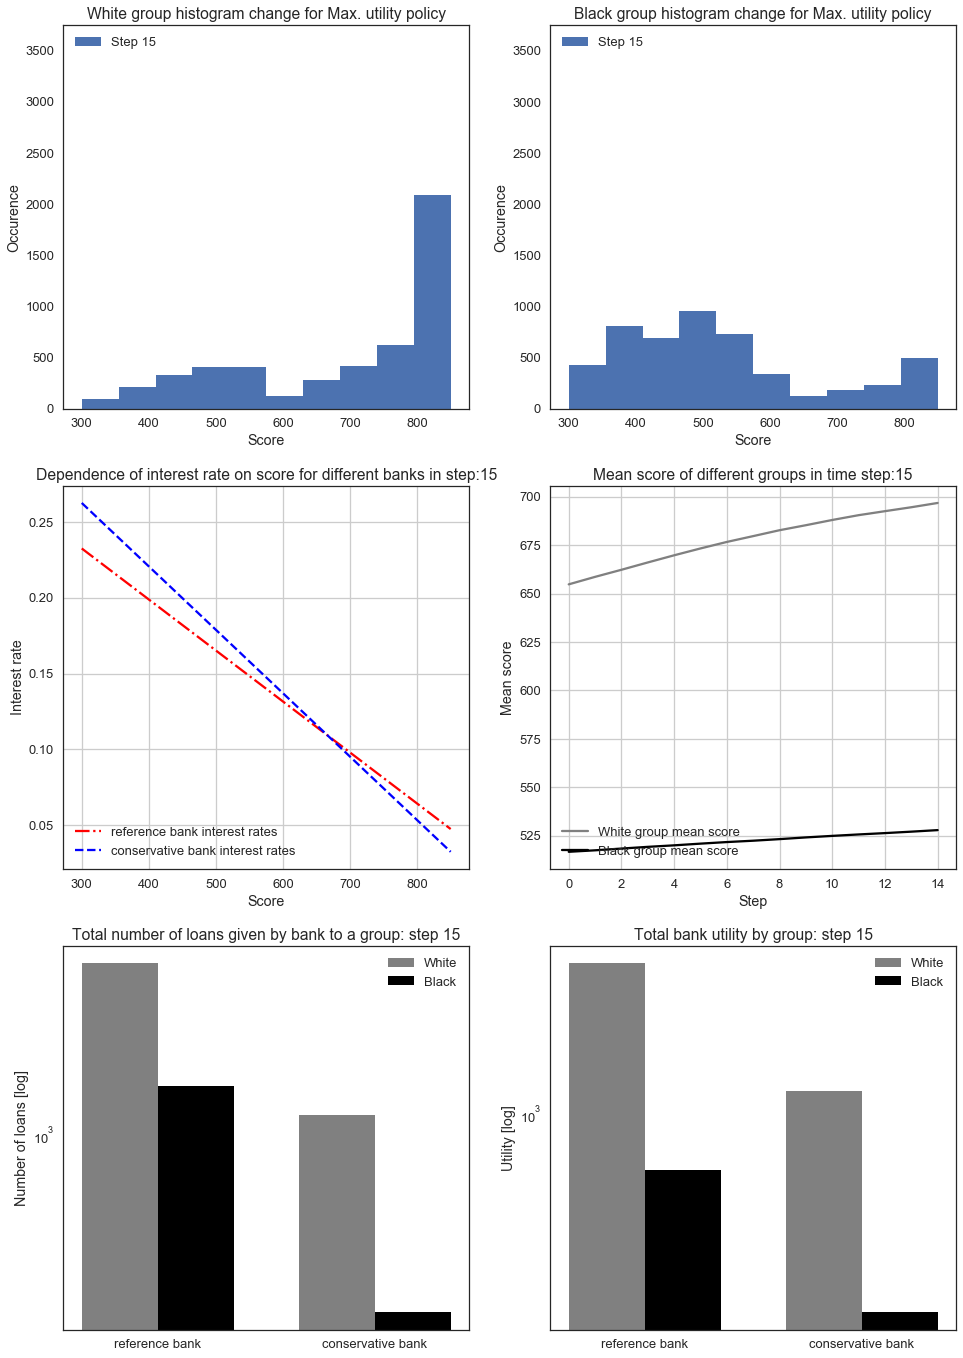

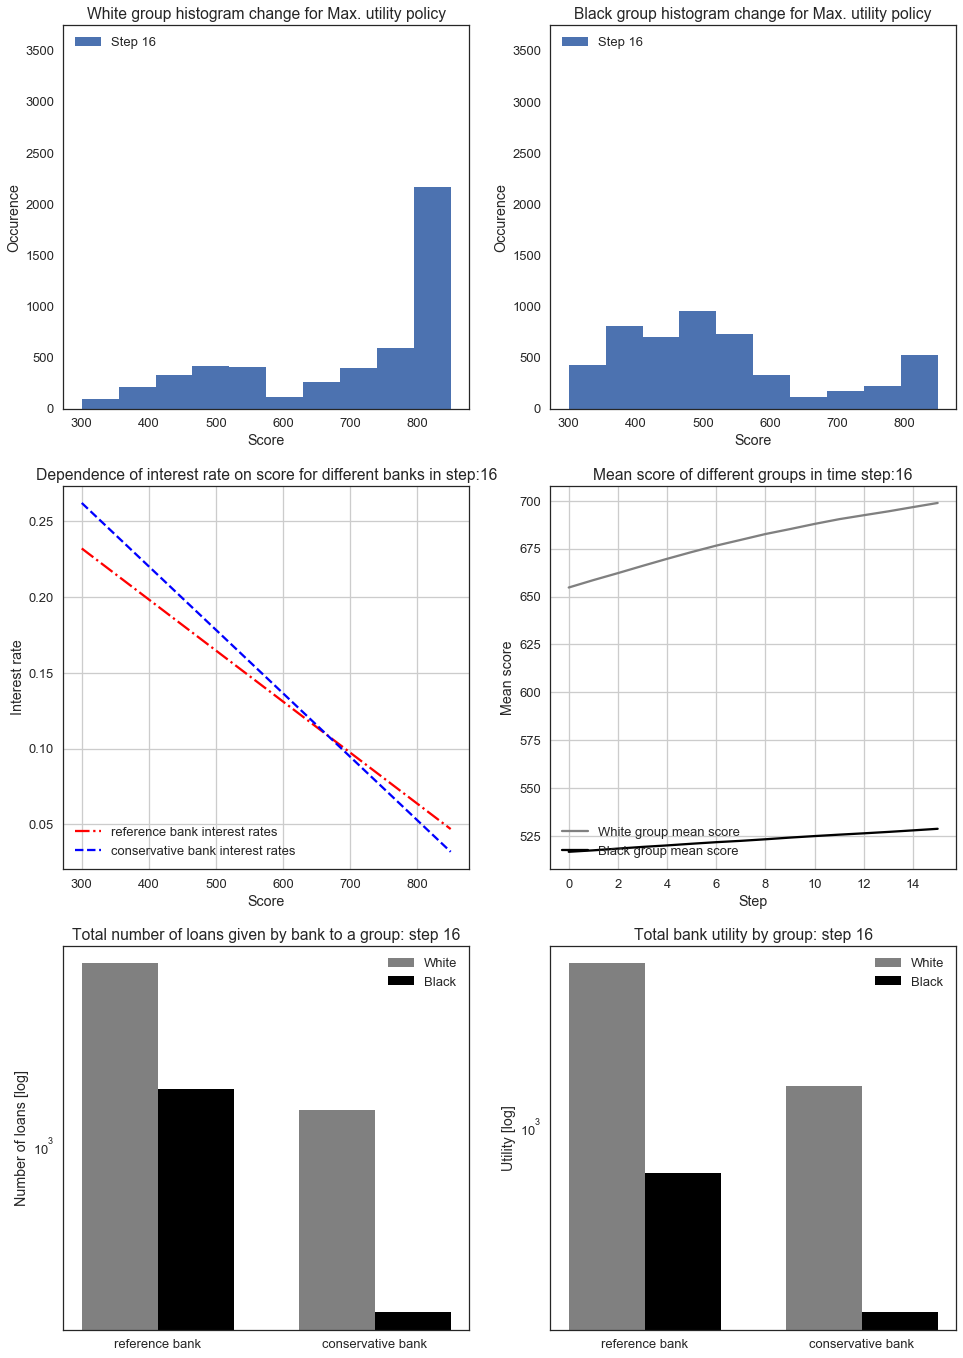

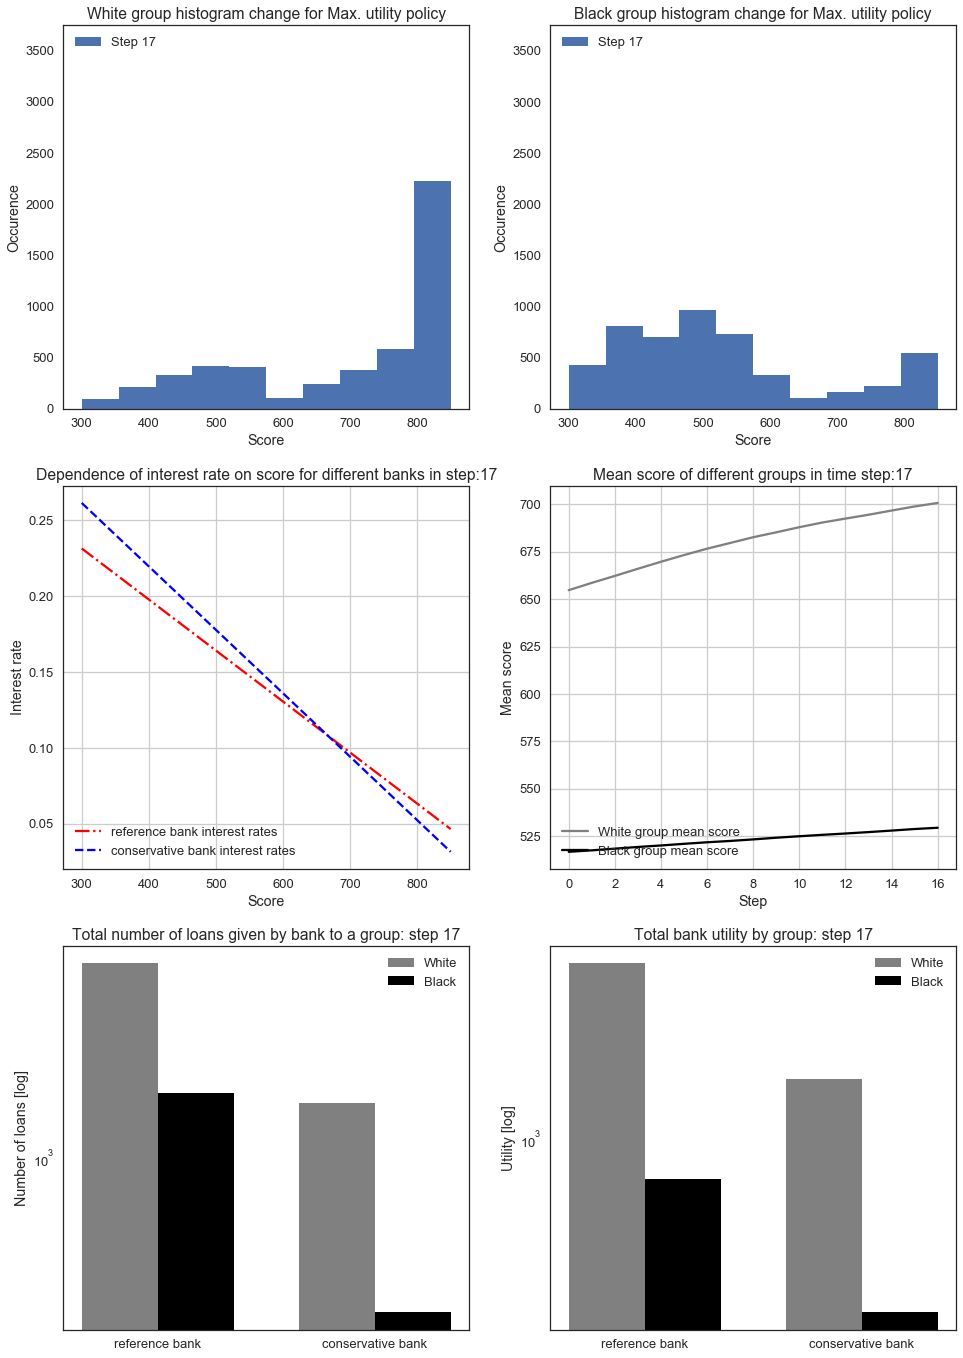

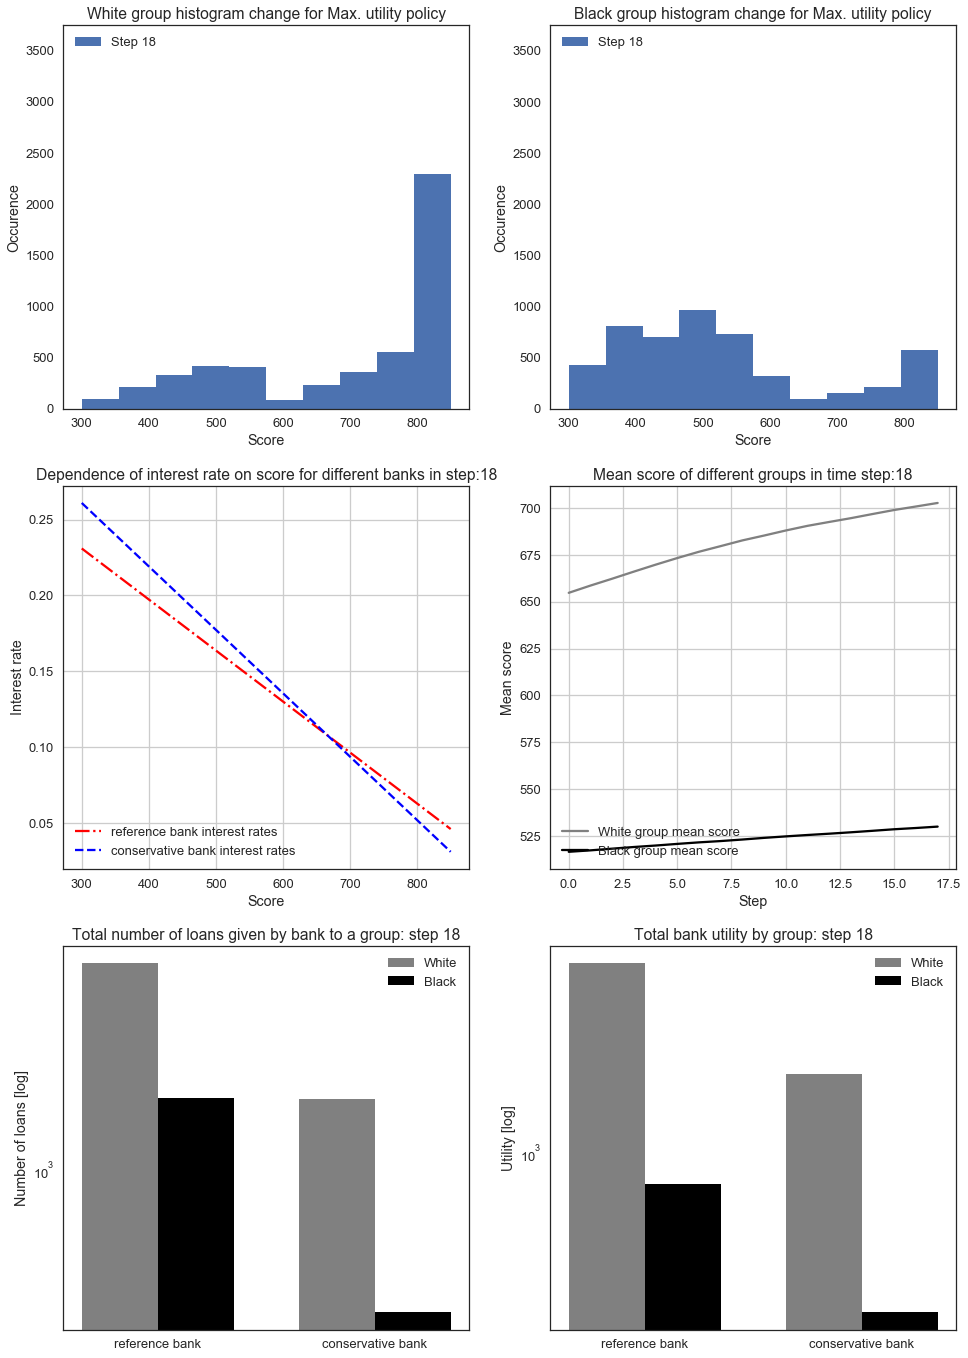

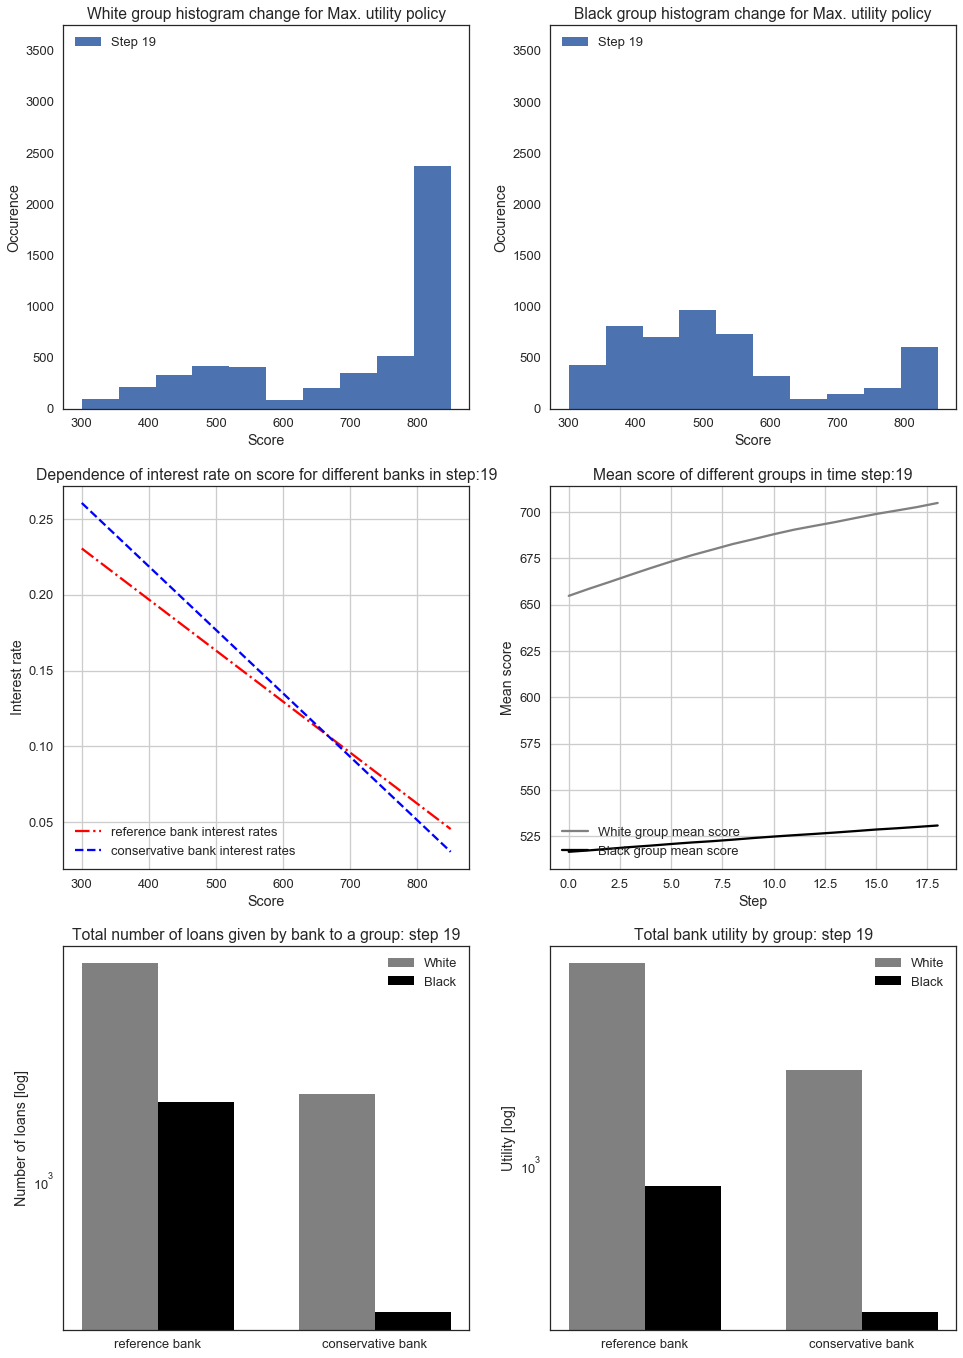

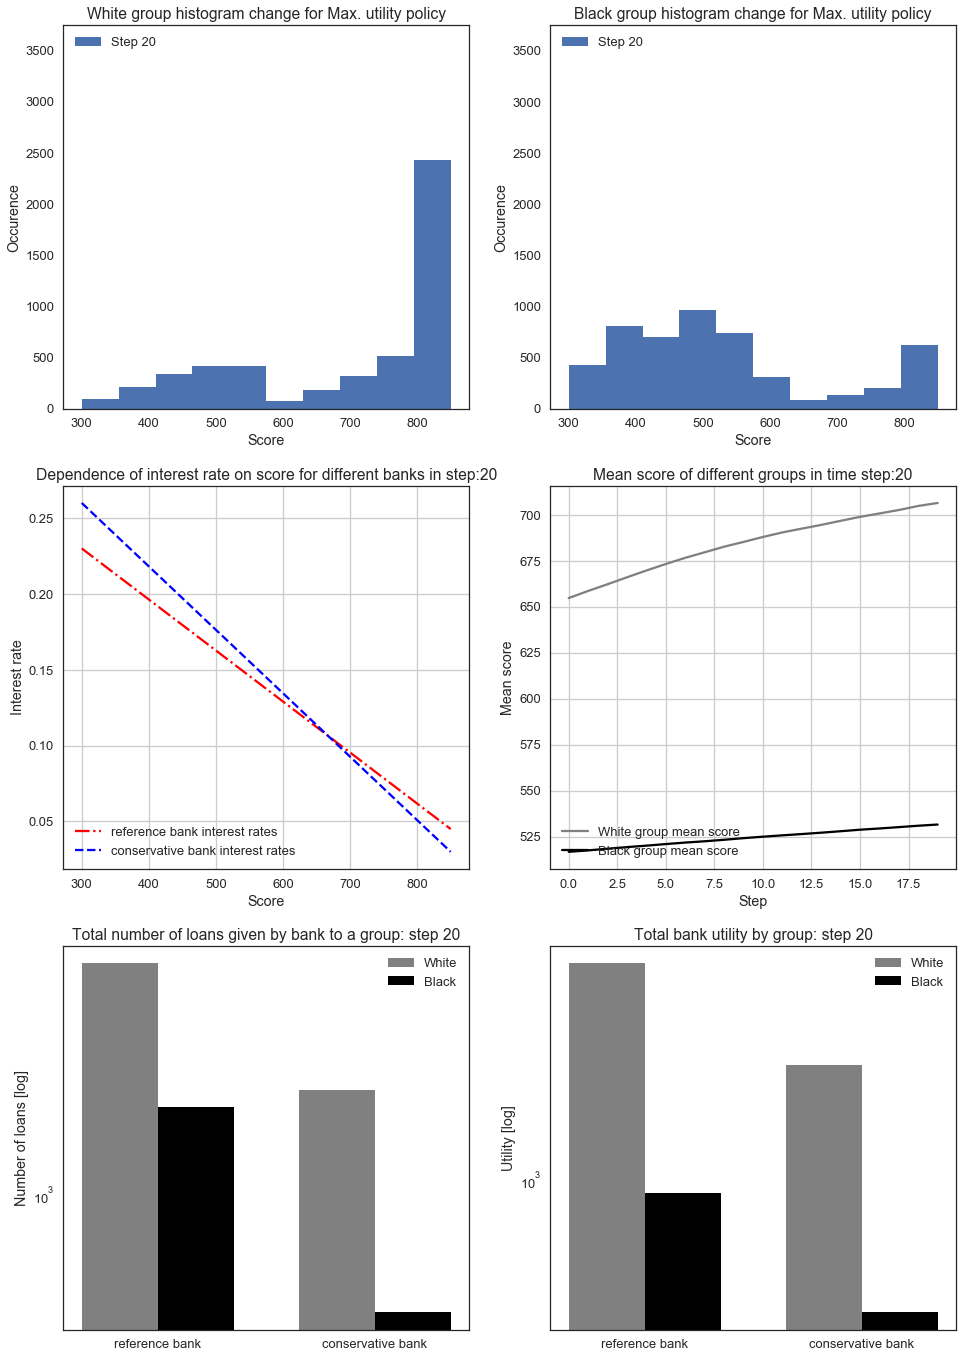

In [77]:
#init values
for bank in banks:
    for group in groups:
        bank.N_loans[group.name] = 0
        bank.total_utility[group.name] = 0




mean_group_score_curve = {groups[0].name:[],groups[1].name:[]}
for time in range(0, time_steps):
    #Before
    #Get expected bank utility and set the bank selection rate
    for i in range(0,len(banks)):
        for group in groups:
            utility=0
            utility_curve = []
            for k in range(0, group.size):
                customer_score = banks[i].get_expected_customer_score(mu_market, group.scores[k])
                utility += banks[i].get_customer_evaluation_utility(customer_score, group)
                utility_curve.append(utility)
            banks[i].set_expected_group_utility_curve(group, utility_curve)
            banks[i].set_group_selection_rate(group)
            #banks[i].plot_expected_group_utility_curve(group)
            #group.plot_histogram(mu_market)

#    mu_market.plot_bank_interest_rates(banks)

    
    
    #During
    utilities = {}
    utility_curves = {}

    for group in groups:
        
#        group.plot_histogram(mu_market)
        
        tmp_utilities = np.zeros(len(banks))
        tmp_utility_curves = []
        for k in range(0, len(banks)):
            tmp_utility_curves.append([])
        
        #select part of customer base
        customers = np.sort(random.sample(range(0, group.size), int(group.size*group.loan_demand)))
        #go over all customers
        for j in customers:
            best_bank = None
            best_interest_rate = np.Infinity
            
            # check which bank gives best interest rate
            for k in range(len(banks)):
                if j/group.size <= banks[k].group_selection_rate[group.name]:
                    expected_customer_score = banks[k].get_expected_customer_score(mu_market, group.scores[j])
                    interest_rate = banks[k].score_interest_rates[expected_customer_score]
                    if interest_rate < best_interest_rate and interest_rate < group.interest_rate_limit:
                        best_interest_rate = interest_rate
                        best_bank = k

            #print(best_bank)
            if best_bank is not None:
                #get loan outcome and change score
                banks[best_bank].N_loans[group.name] += 1 
                real_customer_score = group.scores[j]
                loan_outcome = group.get_repay_outcome(group.score_repay_prob[real_customer_score])
                expected_customer_score = banks[best_bank].get_expected_customer_score(mu_market, group.scores[j])

                if loan_outcome:
                    group.repaid(mu_market, j)
                else:
                    group.default(mu_market, j)
                
                #get bank utility
                utility_change = banks[best_bank].get_customer_utility(expected_customer_score, group, loan_outcome)
                tmp_utilities[best_bank] += utility_change 
                banks[best_bank].total_utility[group.name] += utility_change
                tmp_utility_curves[best_bank] = np.append(tmp_utility_curves[best_bank], tmp_utilities[best_bank])

        utilities[group.name] = tmp_utilities
        utility_curves[group.name] = tmp_utility_curves
        group.sort_scores()
        mean_group_score_curve[group.name].append(group.get_mean_score())
        print(group.name + " group mean score: " + str(group.get_mean_score())+ " at step: " + str(mu_market.step))
        #group.plot_histogram(mu_market)

    mu_market.step += 1
    
    
    #After
    #adjust interest rate, we will need market share and utilities for this
    for i in range(len(banks)):

        bank_clients = 0
        total_clients = 0
        max_expected_utility = 0
        real_utility = 0
        #calculate market share and utilities
        for group in groups:
            banks[i].real_group_utility_curve[group.name] = utility_curves[group.name][i]
            total_clients += group.size * group.loan_demand * banks[i].group_selection_rate[group.name]
            bank_clients += len(banks[i].real_group_utility_curve[group.name])   
            max_expected_utility += np.max(banks[i].expected_group_utility_curve[group.name])

            if len(banks[i].real_group_utility_curve[group.name])>0:
                real_utility += banks[i].real_group_utility_curve[group.name][-1]                                     

        banks[i].market_share = bank_clients/total_clients 
#        print("Market share " + banks[i].name + " bank: " + str(banks[i].market_share))
        #change interest rate according to actual market share and utility
        if banks[i].market_share >= 1/len(banks) and real_utility >= max_expected_utility/len(banks):
            banks[i].change_interest_rate(interest_change_up, mu_market)
        else:
            banks[i].change_interest_rate(interest_change_down, mu_market)

    mu_market.plot_market_situation(banks, groups, mean_group_score_curve)

In [ ]:
mu_market.plot_bank_interest_rates(banks)

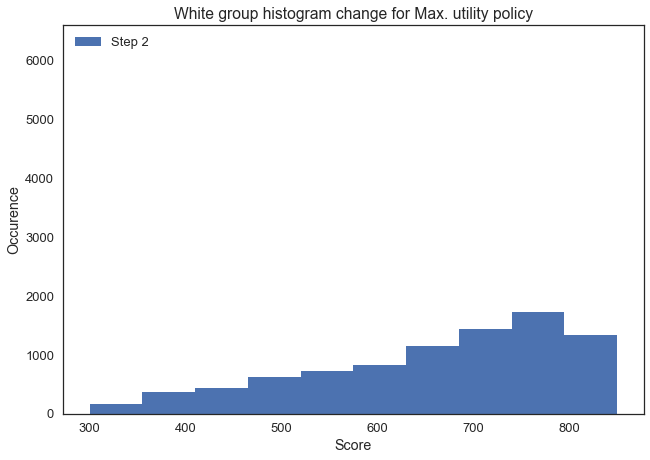

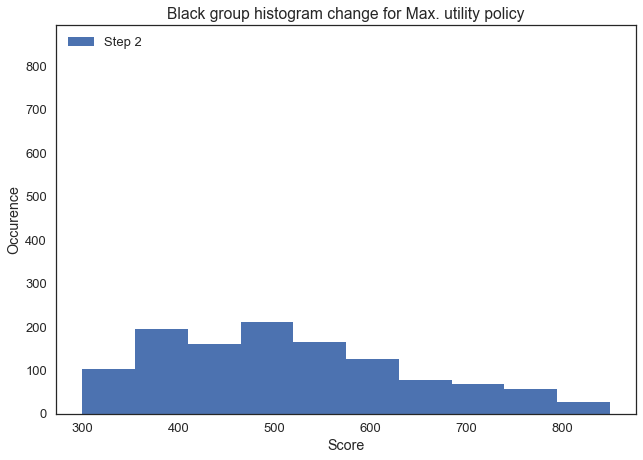

In [8]:
for group in groups:
    group.plot_histogram(mu_market)

1

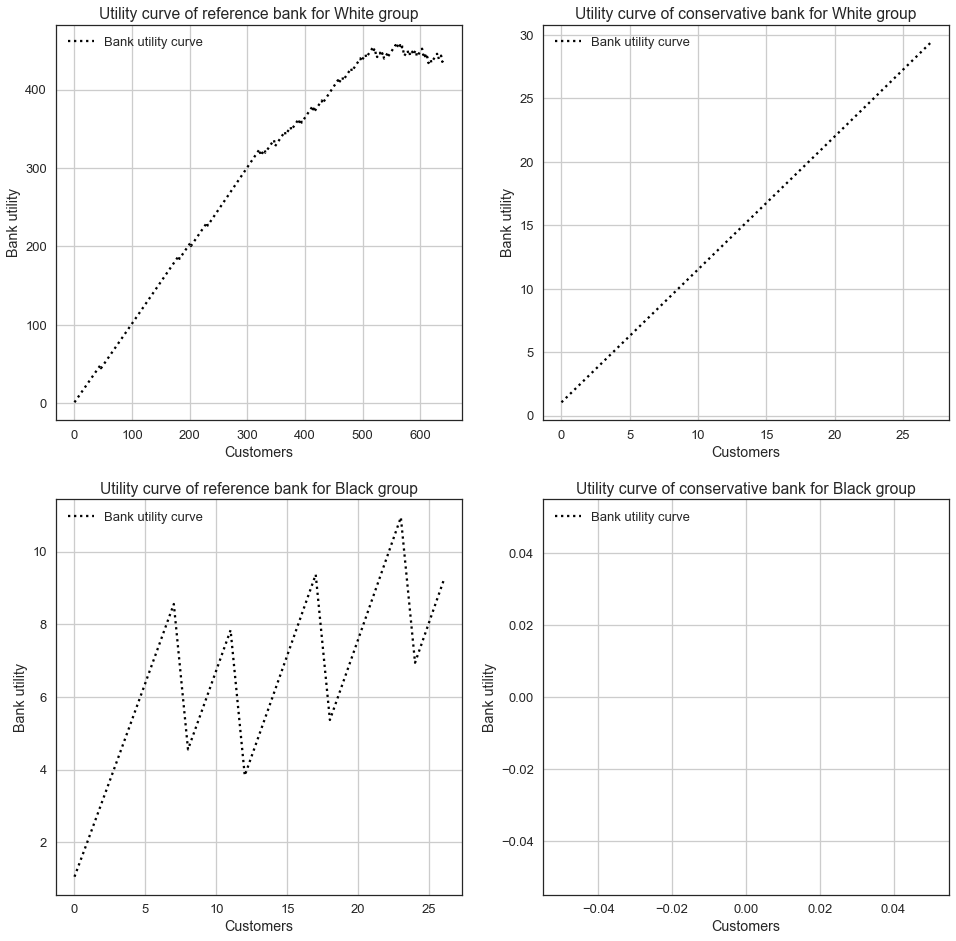

In [9]:
mu_market.plot_bank_utility_curves(banks, groups)